[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Ticker          ^VIX
Date                
2025-01-02  0.001276
2025-01-03  0.001032
2025-01-06  0.001021
2025-01-07  0.001260
2025-01-08  0.001243
...              ...
2025-08-08  0.000911
2025-08-11  0.001048
2025-08-12  0.000861
2025-08-13  0.000833
2025-08-14  0.000873

[154 rows x 1 columns]


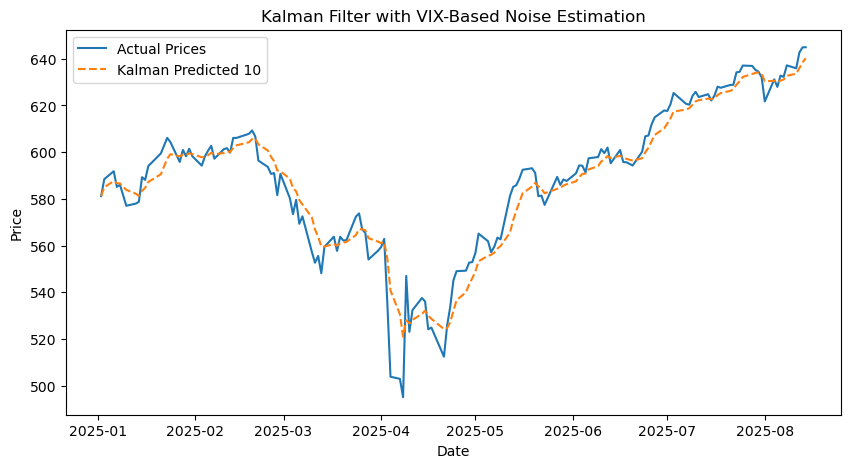

In [4]:
import numpy as np
import polars as pl
import yfinance as yf
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Fetch real stock data (SPY) and VIX data
spy = yf.download("SPY", start="2025-01-01")["Close"]
vix = yf.download("^VIX", start="2025-01-01")["Close"]

# Ensure VIX and SPY have the same dates
vix = vix.reindex(spy.index, method='ffill') 

# Convert VIX to daily variance (Process Noise Q)
daily_volatility = vix / 100 / np.sqrt(252) 
Q_vix = daily_volatility ** 2  

# Scale measurement noise (Observation Noise R) using scaling factors
scaling_factor = 5 
R_vix_10 = scaling_factor * Q_vix * 2
print(R_vix_10)
# Reshape Q and R to 2D arrays with consistent dimensions
Q_vix_values = Q_vix.values.reshape(-1, 1)  
R_vix_10_values = R_vix_10.values.reshape(-1, 1)  


kf_10 = KalmanFilter(initial_state_mean=spy.iloc[0],
                  n_dim_obs=1,
                  n_dim_state=1,
                  transition_covariance=Q_vix_values[0],  
                  observation_covariance=R_vix_10_values[0])  

# Apply Kalman Filter with 10x scaling factor for observation noise
filtered_state_means_10, _ = kf_10.filter(spy.values)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(spy.index, spy, label="Actual Prices")
plt.plot(spy.index, filtered_state_means_10, label="Kalman Predicted 10", linestyle="dashed")
plt.legend()
plt.title("Kalman Filter with VIX-Based Noise Estimation")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [12]:
pl_spy = pl.from_pandas(spy)
pl_kalman = pl.DataFrame({"kalman_pred": filtered_state_means_10})
data = pl.concat([pl_spy,pl_kalman], how='horizontal')
data


SPY,kalman_pred
f64,"array[f64, 1]"
581.168457,[581.168457]
588.435059,[584.972671]
591.824768,[587.60425]
585.134766,[586.798778]
585.989685,[586.557003]
…,…
637.179993,[632.733772]
635.919983,[633.594546]
642.690002,[636.05174]


In [15]:
pl_spy


SPY
f64
581.168457
588.435059
591.824768
585.134766
585.989685
…
637.179993
635.919983
642.690002
